In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

SEED = 42
random.seed(SEED)
np.random.seed(SEED)         

In [26]:
def generate_lorenz(length, dt=0.01, sigma=10.0, rho=28.0, beta=8/3, noise=0):
    
    """
    Args:
        length         (int):      Number of time steps to generate.
        dt             (float):    Time step size.
        sigma          (float):    Lorenz parameter sigma.
        rho            (float):    Lorenz parameter pho.
        beta           (float):    Lorenz parameter beta.
        initial_state  (tuple):    Initial (x0, y0, z0). Random if None.
        noise          (float):    Std-dev of additive Gaussian noise on each variable.
        seed           (int/None): Random seed for reproducibility.

    Returns:
        t -> time vector
        traj -> the Lorenz trajectory (x, y, z) at each time.
    """

    rng = np.random.default_rng(SEED)
    state = rng.standard_normal(3)

    t = np.linspace(0, dt*(length-1), length)
    traj = np.zeros((length, 3))
    traj[0] = state

    def lorenz_rhs(s): #definition of lorentz equations
        x, y, z = s
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return np.array([dx, dy, dz])

    for i in range(1, length):  # 4th-order Runge–Kutta integration
        s = traj[i-1]
        k1 = lorenz_rhs(s)
        k2 = lorenz_rhs(s + 0.5 * dt * k1)
        k3 = lorenz_rhs(s + 0.5 * dt * k2)
        k4 = lorenz_rhs(s + dt * k3)
        traj[i] = s + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    if noise > 0: #eventuale
        traj += np.random.normal(scale=noise, size=traj.shape)

    return t, traj

def generate_lorenz_init(length: int, init_state: np.ndarray, seed: int, dt: float = 0.01, sigma: float = 10.0, rho: float = 28.0, beta: float = 8/3, noise: float = 0.0):
    """Generate a Lorenz trajectory via 4-th order Runge-Kutta.

    Args:
        length (int): number of time steps.
        dt (float): integration step.
        sigma, rho, beta (float): Lorenz parameters.
        init_state (sequence or None): (x0, y0, z0). If *None*, draw from N(0,1).
        noise (float): Gaussian noise std-dev added to each state variable.
        seed (int|None): RNG seed for reproducibility (affects random init & noise).

    """
    rng = np.random.default_rng(seed)

    if init_state is None:
        state = rng.standard_normal(3)
    else:
        state = np.asarray(init_state, dtype=float).copy()
        if state.shape != (3,):
            raise ValueError("init_state must be length‑3 (x0,y0,z0)")

    t = np.linspace(0, dt*(length-1), length)
    traj = np.zeros((length, 3))
    traj[0] = state

    def lorenz_rhs(s):
        x, y, z = s
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return np.array([dx, dy, dz])

    for i in range(1, length):
        s = traj[i-1]
        k1 = lorenz_rhs(s)
        k2 = lorenz_rhs(s + 0.5 * dt * k1)
        k3 = lorenz_rhs(s + 0.5 * dt * k2)
        k4 = lorenz_rhs(s + dt * k3)
        traj[i] = s + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    if noise > 0:
        traj += rng.normal(scale=noise, size=traj.shape)

    return t, traj

def split_train_val_test(u, y, train_frac=0.6, val_frac=0.2):

    if train_frac + val_frac >= 1.0:
        raise ValueError("train_frac + val_frac must be < 1.0")
    N = len(u)
    i_train = int(train_frac * N)
    i_val   = i_train + int(val_frac * N)

    return ((u[:i_train], y[:i_train]), (u[i_train:i_val], y[i_train:i_val]), (u[i_val:], y[i_val:]))

In [27]:
dt = 0.01
length=10000
np.random.seed(SEED) 
t, traj = generate_lorenz(length=10000, dt=0.01)

traj.shape

(10000, 3)

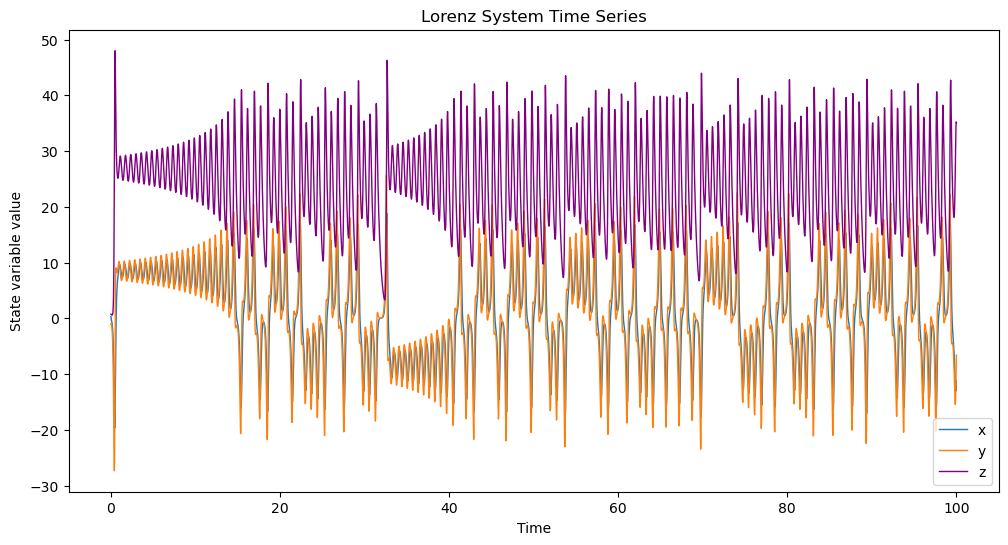

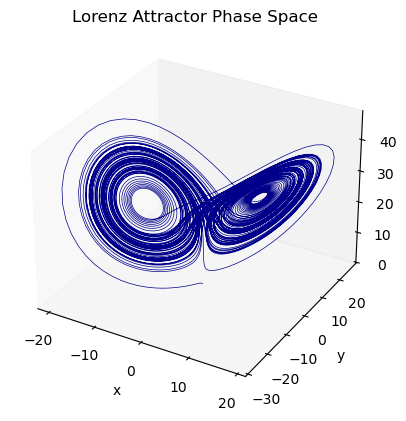

In [28]:
x, y, z = traj.T

plt.figure(figsize=(12, 6))
plt.plot(t, x, lw= 1)
plt.plot(t, y, lw= 1)
plt.plot(t, z, color= "purple", lw= 1)
plt.xlabel('Time')
plt.ylabel('State variable value')
plt.title('Lorenz System Time Series')
plt.legend(['x', 'y', 'z'])
plt.show()

# 3D phase-space attractor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5, color='darkblue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Lorenz Attractor Phase Space')
ax.grid(False)  
plt.show()


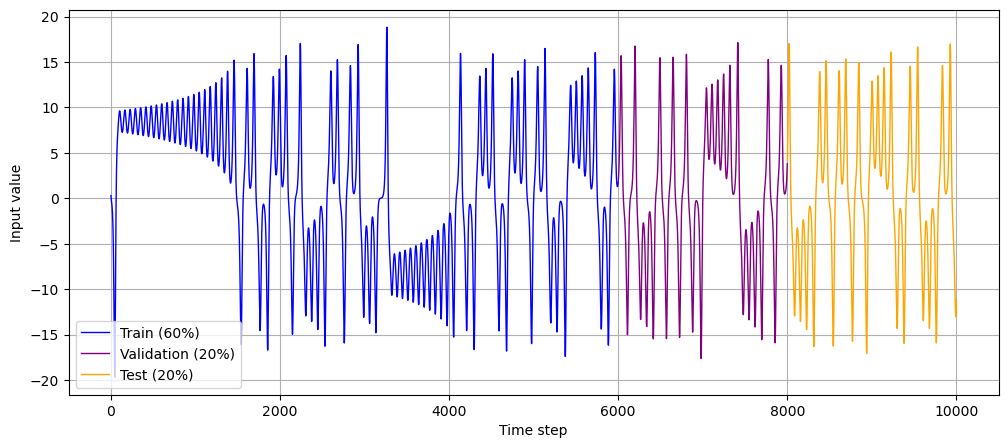

In [29]:
train_frac = 0.6
val_frac = 0.2

(u_tr, y_tr), (u_val, y_val), (u_te, y_te) = split_train_val_test(x, y, train_frac, val_frac)

i_train = len(u_tr)
i_val = i_train + len(u_val)
time = np.arange(length)

plt.figure(figsize=(12, 5))
plt.plot(time[:i_train], u_tr, label='Train (60%)', linewidth=1, color='blue')
plt.plot(time[i_train:i_val], u_val, label='Validation (20%)', linewidth=1, color='Purple')
plt.plot(time[i_val:], u_te, label='Test (20%)', linewidth=1, color='orange')

plt.xlabel('Time step')
plt.ylabel('Input value')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# deviazione standard di y_tr
std_y_tr = np.std(y_tr)
print(f"Standard deviation of y_tr: {std_y_tr:.4f}")
# deviazione standard di y_te
std_y_te = np.std(y_te)
print(f"Standard deviation of y_te: {std_y_te:.4f}")

Standard deviation of y_tr: 8.8769
Standard deviation of y_te: 9.2010


### Chaotic divergence of two trajectories 

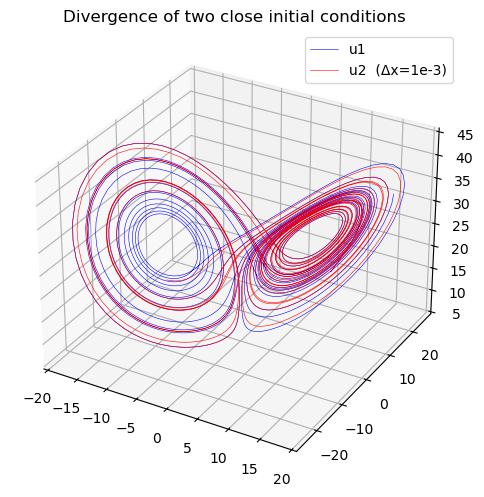

In [30]:
np.random.seed(SEED)  

init1 = np.array([10.0, 12.0, 18.0])
init2 = init1.copy()
init2[0] += 1e-3

steps = 2250
_, traj1 = generate_lorenz_init(length=steps, dt=dt, init_state=init1, seed = 42)
_, traj2 = generate_lorenz_init(length=steps, dt=dt, init_state=init2, seed = 42)

x1, y1, z1 = traj1.T
x2, y2, z2 = traj2.T

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, y1, z1, lw=0.4, color='blue', label='u1')
ax.plot(x2, y2, z2, lw=0.4, color='red', label='u2  (Δx=1e‑3)')
ax.set_title('Divergence of two close initial conditions')
ax.legend()
plt.tight_layout(); plt.show()

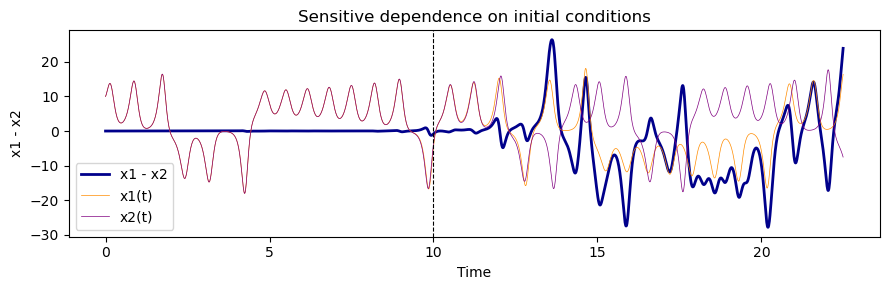

In [31]:


plt.figure(figsize=(9,3))
plt.plot(np.arange(steps)*dt, x1 - x2, color='darkblue', label='x1 - x2', lw=2)
plt.plot(np.arange(steps)*dt, x1 , color='darkorange', label='x1(t)', lw=0.5)
plt.plot(np.arange(steps)*dt, x2 , color='purple', label='x2(t)', lw=0.5)
plt.axvline(1000*dt, color='k', ls='--', lw=0.8)
plt.xlabel('Time'); plt.ylabel('x1 - x2')
plt.title('Sensitive dependence on initial conditions')
plt.legend()
plt.tight_layout(); plt.show()

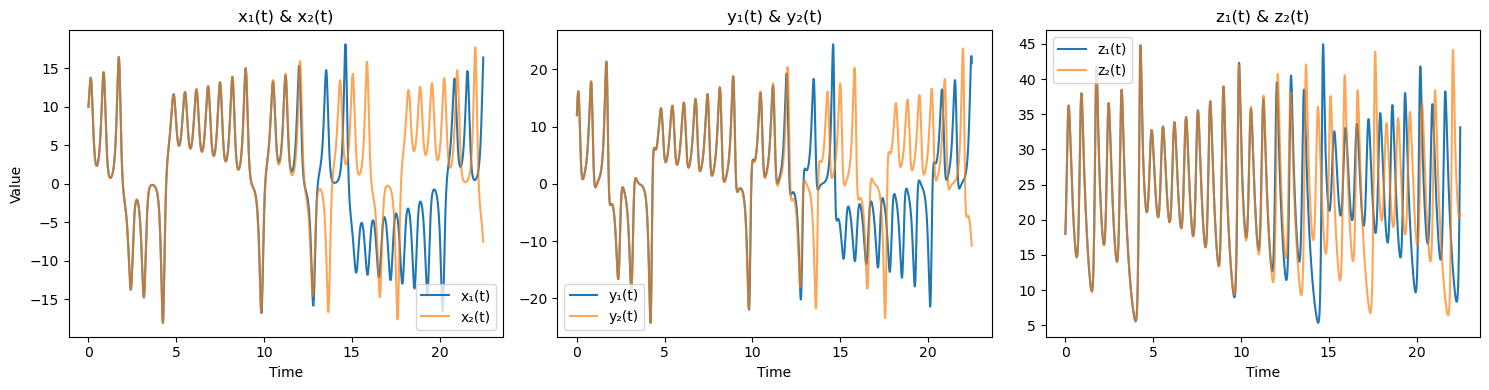

In [32]:

x1, y1, z1 = traj1.T
x2, y2, z2 = traj2.T
t = np.arange(len(x1)) * dt  
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

axes[0].plot(t, x1, label='x₁(t)')
axes[0].plot(t, x2, label='x₂(t)', alpha=0.7)
axes[0].set_title('x₁(t) & x₂(t)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(t, y1, label='y₁(t)')
axes[1].plot(t, y2, label='y₂(t)', alpha=0.7)
axes[1].set_title('y₁(t) & y₂(t)')
axes[1].set_xlabel('Time')
axes[1].legend()

axes[2].plot(t, z1, label='z₁(t)')
axes[2].plot(t, z2, label='z₂(t)', alpha=0.7)
axes[2].set_title('z₁(t) & z₂(t)')
axes[2].set_xlabel('Time')
axes[2].legend()

plt.tight_layout()
plt.show()


In [33]:
import numpy as np
from scipy.integrate import odeint
import nolds

def lorenz(state, t, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

dt = 0.01
t = np.arange(0.0, 50.0, dt)
x0 = [1.0, 1.0, 1.0]
sol = odeint(lorenz, x0, t)
x_ts = sol[:, 0]

emb_dim = 3
tau     = int(0.1 / dt)
min_tsep = int(10)

lyap_lorenz = nolds.lyap_e(x_ts,
                           emb_dim=emb_dim,
                           tau=tau,
                           min_tsep=min_tsep)
print("Spettro λ (Lorenz):", lyap_lorenz)

ValueError: emb_dim - 1 must be divisible by matrix_dim - 1!

In [ ]:
import sys
!{sys.executable} -m pip install nolds

In [ ]:
import numpy as np
from scipy.integrate import odeint
import nolitsa

# Definizione di Ma-Chen (uguale a prima)
def ma_chen_rhs(x, a=0.01, b=0.8, c=0.1):
    X, Y, Z = x
    dx = Z + (Y - a)*X
    dy = 1.0 - b*Y - X**2
    dz = -X - c*Z
    return [dx, dy, dz]

# 1) Simulo per ottenere x(t)
dt = 0.01
t = np.arange(0.0, 50.0, dt)
x0 = [0.5, 0.5, 0.5]
sol_mc = odeint(ma_chen_rhs, x0, t)
x_mc = sol_mc[:, 0]  # prendo la componente x(t)

# 2) Applico nolitsa.lyaprosen per stimare λ₁
emb_dim = 3
tau = int(0.1 / dt)   # ritardo ≈ 0.1 s
min_tsep = int(10)    # distanza minima tra punti

# lyaprosen restituisce array di divergenze locali; di solito prendiamo la pendenza in un tratto lineare
lyap_ros = nolitsa.lyaprosen(x_mc, embdim=emb_dim, tau=tau, min_tsep=min_tsep)
# Scegli un intervallo dove la curva è lineare (es. dai campioni 200 a 500)
lam1_est = np.mean(lyap_ros[200:500])

print("Stima λ₁ (Ma-Chen) con nolitsa:", lam1_est)

ModuleNotFoundError: No module named 'nolitsa'

In [ ]:
import numpy as np

# --- Sistema di Lorenz: implementazione RK4 variazionale ---
def lorenz_rhs(x, sigma=10.0, rho=28.0, beta=8.0/3.0):
    return np.array([
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    ])

def lorenz_jacobian(x, sigma=10.0, rho=28.0, beta=8.0/3.0):
    return np.array([
        [-sigma,       sigma,      0   ],
        [rho - x[2],   -1,       -x[0] ],
        [x[1],         x[0],     -beta ]
    ])

# --- Sistema Ma–Chen: restituisce np.array –, non lista ---
def ma_chen_rhs(x, a=3.0, b=0.1, c=1.0):
    X, Y, Z = x
    dx = Z + (Y - a) * X
    dy = 1.0 - b * Y - X**2
    dz = -X - c * Z
    return np.array([dx, dy, dz])

def ma_chen_jacobian(x, a=3.0, b=0.1, c=1.0):
    X, Y, Z = x
    return np.array([
        [Y - a,    X,    1    ],
        [-2*X,    -b,    0    ],
        [-1,       0,   -c    ]
    ])

# --- Funzione generica per calcolare gli esponenti di Lyapunov con RK4 variazionale ---
def compute_lyapunov_rk4(rhs_func, jacobian_func, dt, total_time, x0):
    """
    Calcola [λ1, λ2, λ3] per un sistema 3D tramite RK4 su traiettoria
    e sistema variazionale Q' = J(x)·Q.
    - rhs_func(x): restituisce np.array([dx, dy, dz]).
    - jacobian_func(x): restituisce la matrice 3×3 di J(x).
    - dt: passo di integrazione.
    - total_time: tempo netto su cui accumulare.
    - x0: condizione iniziale (lunghezza 3).
    Ritorna array [λ1, λ2, λ3].
    """
    num_steps = int(total_time / dt)
    x = np.array(x0, dtype=float)
    Q = np.eye(3)
    lyapunov_sums = np.zeros(3)
    
    for _ in range(num_steps):
        # --- 1) RK4 per la traiettoria principale ---
        k1 = rhs_func(x)
        k2 = rhs_func(x + 0.5 * dt * k1)
        k3 = rhs_func(x + 0.5 * dt * k2)
        k4 = rhs_func(x + dt * k3)
        x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        
        # --- 2) RK4 per i vettori tangenti Q (matrice 3×3) ---
        def tangent_deriv(Q_mat):
            return jacobian_func(x) @ Q_mat
        
        K1 = tangent_deriv(Q)
        K2 = tangent_deriv(Q + 0.5 * dt * K1)
        K3 = tangent_deriv(Q + 0.5 * dt * K2)
        K4 = tangent_deriv(Q + dt * K3)
        Q = Q + (dt / 6.0) * (K1 + 2*K2 + 2*K3 + K4)
        
        # --- 3) Ortonormalizzazione via QR e accumulo log(diag(R)) ---
        Q, R = np.linalg.qr(Q)
        lyapunov_sums += np.log(np.abs(np.diag(R)))
    
    return lyapunov_sums / total_time

# Parametri di integrazione
dt = 0.001
total_time = 200.0
transient = 50.0
x0_lorenz = [1.0, 1.0, 1.0]

# --- 1) Calcolo λ per Lorenz (scarto transient) ---
num_transient_steps = int(transient / dt)
x = np.array(x0_lorenz, dtype=float)
for _ in range(num_transient_steps):
    k1 = lorenz_rhs(x)
    k2 = lorenz_rhs(x + 0.5 * dt * k1)
    k3 = lorenz_rhs(x + 0.5 * dt * k2)
    k4 = lorenz_rhs(x + dt * k3)
    x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

lyap_lorenz = compute_lyapunov_rk4(
    rhs_func=lorenz_rhs,
    jacobian_func=lorenz_jacobian,
    dt=dt,
    total_time=total_time - transient,
    x0=x
)
print("Lyapunov exponents (Lorenz):", lyap_lorenz)


# --- 2) Calcolo λ per Ma–Chen (scarto transient) ---
x0_ma_chen = [0.5, 0.5, 0.5]
x = np.array(x0_ma_chen, dtype=float)
for _ in range(num_transient_steps):
    k1 = ma_chen_rhs(x)
    k2 = ma_chen_rhs(x + 0.5 * dt * k1)
    k3 = ma_chen_rhs(x + 0.5 * dt * k2)
    k4 = ma_chen_rhs(x + dt * k3)
    x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

lyap_ma_chen = compute_lyapunov_rk4(
    rhs_func=ma_chen_rhs,
    jacobian_func=ma_chen_jacobian,
    dt=dt,
    total_time=total_time - transient,
    x0=x
)
print("Lyapunov exponents (Ma–Chen):", lyap_ma_chen)

Lyapunov exponents (Lorenz): [  0.89376617  -0.02047793 -14.5399549 ]
Lyapunov exponents (Ma–Chen): [ 0.15556844  0.00206875 -0.50828997]
